In [21]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import psycopg2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

### PCA And MI score for Pickup Data

#### Reading the featured pickup data from postgresql

In [22]:
# Create a connection to the PostgreSQL database
conn = psycopg2.connect(
    dbname="postgres", 
    user="postgres", 
    password="root", 
    host="localhost", 
    port="5432"
)

# Query to get data
query = "SELECT * FROM feature_engg_pickup_data"

# Use pandas to read the SQL query result directly into a DataFrame
df = pd.read_sql(query, conn)

# Close the connection
conn.close()

C:\Users\Dusty\AppData\Local\Temp\ipykernel_30864\3798793896.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005691 entries, 0 to 4005690
Data columns (total 17 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   order_id                 int64         
 1   pickup_time              datetime64[ns]
 2   accept_time              datetime64[ns]
 3   hour_of_day              int64         
 4   day_of_week              int64         
 5   month                    int64         
 6   pickup_eta_minutes       float64       
 7   pickup_time_delay        float64       
 8   pickup_distance_km       float64       
 9   cluster                  int64         
 10  avg_pickup_time_minutes  float64       
 11  pickup_order_count       int64         
 12  city                     object        
 13  city_order_count         int64         
 14  is_delayed               object        
 15  speed_kmh                int64         
 16  speed_status             object        
dtypes: datetime64[ns](2), float

#### Principal Component Analysis (PCA): Reduce high-dimensional data while maintaining variance.

In [23]:
# 1. Preprocessing: Handling categorical variables
# Encoding categorical variables
label_encoder = LabelEncoder()
df_sample = df.sample(frac=0.2, random_state=42)
categorical_cols = df_sample.select_dtypes(include=['object', 'datetime64[ns]']).columns.tolist()
print(f"Categorical Columns: {categorical_cols}")

# 2. Drop the non-numerical columns if they are not required for PCA
# In this case, let's keep only the numeric columns
numerical_columns = df_sample.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df_sample[numerical_columns]

#removing order_id as its not necessary for PCA
df_numeric = df_numeric.drop('order_id', axis=1) 
columns_list = df_numeric.columns.tolist()
print(f"Numerical Columns:", columns_list)

# 3. Standardize the data (PCA is sensitive to scale)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

Categorical Columns: ['pickup_time', 'accept_time', 'city', 'is_delayed', 'speed_status']
Numerical Columns: ['hour_of_day', 'day_of_week', 'month', 'pickup_eta_minutes', 'pickup_time_delay', 'pickup_distance_km', 'cluster', 'avg_pickup_time_minutes', 'pickup_order_count', 'city_order_count', 'speed_kmh']


In [4]:
row_count = df_numeric.shape[0]
print("Number of rows:", row_count)

Number of rows: 801138


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# PCA apply
pca = PCA()
pca.fit(df_scaled)

# Find optimal number of components
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components = (cumulative_variance >= 0.95).argmax() + 1

print(f"Number of components needed for 95% variance: {n_components}")

Number of components needed for 95% variance: 10


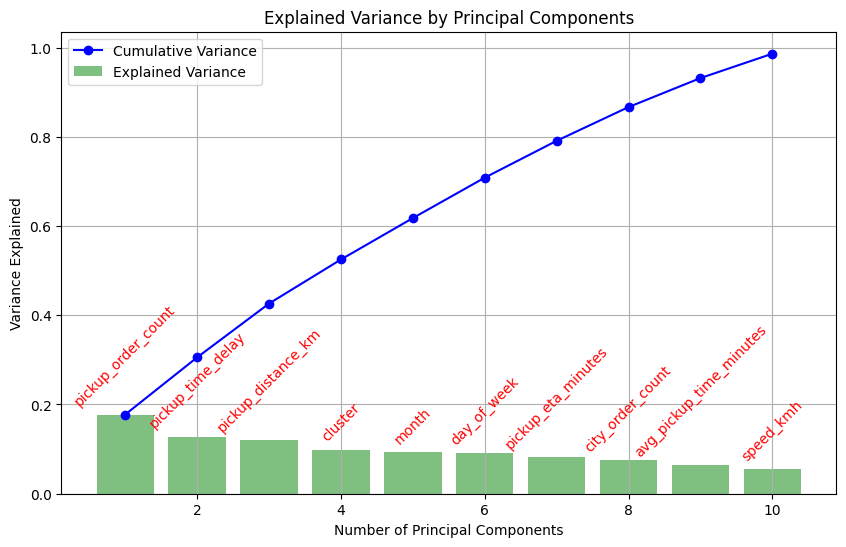

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Get PCA loadings (how original features contribute to each component)
pca_loadings = pd.DataFrame(pca.components_, columns=df_scaled.columns, index=[f'PCA{i+1}' for i in range(n_components)])

# Get top 2 contributing features per PCA component
top_n = 2  # You can change this to 3 if needed
top_features_per_component = pca_loadings.abs().apply(lambda x: x.nlargest(top_n).index.tolist(), axis=1)

# Convert list to string format for annotations
top_features_str = top_features_per_component.apply(lambda x: ', '.join(x))

# Ensure features are annotated only once in the graph
used_features = set()  # To track used features

# Fix for mismatched dimensions
num_components = len(explained_variance)

# Plot Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_components + 1), cumulative_variance, marker='o', linestyle='-', color='b', label='Cumulative Variance')
plt.bar(range(1, num_components + 1), explained_variance, alpha=0.5, align='center', color='g', label='Explained Variance')

# Annotate the bars with the most important features (only if not used before)
for i, (var, features) in enumerate(zip(explained_variance, top_features_per_component)):
    for feature in features:
        if feature not in used_features:
            plt.text(i + 1, var + 0.02, feature, ha='center', fontsize=10, rotation=45, color='red')
            used_features.add(feature)  # Mark feature as used
            break  # Only take the first new unique feature

plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Get the PCA loadings (component matrix)
pca_loadings = pd.DataFrame(pca.components_, columns=df_scaled.columns, index=[f'PCA{i+1}' for i in range(n_components)])

# Take absolute values to see overall importance (since negative and positive both contribute)
pca_feature_importance = pca_loadings.abs().sum(axis=0)

# Rank features by importance
sorted_features = pca_feature_importance.sort_values(ascending=False)

# Select top N original features based on cumulative importance
top_n = 10  # Choose based on requirement
best_original_features = sorted_features.index[:top_n].tolist()

print("Best Original Features for Model Development:", best_original_features)

# Create a new DataFrame with selected original features
df_selected_features = df_sample[best_original_features]

Best Original Features for Model Development: ['speed_kmh', 'city_order_count', 'pickup_time_delay', 'pickup_distance_km', 'avg_pickup_time_minutes', 'pickup_eta_minutes', 'month', 'cluster', 'day_of_week', 'pickup_order_count']


In [26]:
df_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005691 entries, 0 to 4005690
Data columns (total 10 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   speed_kmh                int64  
 1   city_order_count         int64  
 2   pickup_time_delay        float64
 3   pickup_distance_km       float64
 4   avg_pickup_time_minutes  float64
 5   pickup_eta_minutes       float64
 6   month                    int64  
 7   cluster                  int64  
 8   day_of_week              int64  
 9   pickup_order_count       int64  
dtypes: float64(4), int64(6)
memory usage: 305.6 MB


In [ ]:
# By looking at graoh above above and top features after PCA having highest variance we'll select these 10 columns fro our model building.

#### Mutual Information (MI) Score: Rank features based on their correlation with ETA & delays.

In [27]:
# Apply Label Encoding for Full Dataset
encoder = LabelEncoder()
df_encoded = df_sample[categorical_cols].apply(lambda col: encoder.fit_transform(col.astype(str)))
# df_encoded_for_delay = df_sample[categorical_cols].drop(columns=['is_delayed'], errors='ignore').apply(lambda col: encoder.fit_transform(col.astype(str)))

# Target variables
y_eta = df_sample['pickup_eta_minutes']  # Continuous target
y_delayed = df_sample['pickup_time_delay']  # Categorical target (binary: 1 or 0)

# Compute Mutual Information for ETA (continuous target)
mi_eta = mutual_info_regression(df_encoded, y_eta)

# Compute Mutual Information for Delays (categorical target)
mi_delayed = mutual_info_regression(df_encoded, y_delayed)

# Create DataFrames to view the results
mi_eta_df = pd.DataFrame({
    'Feature': df_encoded.columns,
    'MI with ETA': mi_eta
}).sort_values(by='MI with ETA', ascending=False)

mi_delayed_df = pd.DataFrame({
    'Feature': df_encoded.columns,
    'MI with Delayed': mi_delayed
}).sort_values(by='MI with Delayed', ascending=False)

# Print the results
print("Mutual Information with ETA (Continuous Target):")
print(mi_eta_df)

print("\nMutual Information with Delays (Categorical Target):")
print(mi_delayed_df)

Mutual Information with ETA (Continuous Target):
        Feature  MI with ETA
0   pickup_time     0.495575
1   accept_time     0.125835
3    is_delayed     0.086736
4  speed_status     0.032106
2          city     0.004063

Mutual Information with Delays (Categorical Target):
        Feature  MI with Delayed
0   pickup_time         2.953639
3    is_delayed         0.580205
4  speed_status         0.085012
1   accept_time         0.014959
2          city         0.009405


In [37]:
# Select Only Important Features, we'll do it only one time as both eta and delay have same Mi score feature columns
important_categorical_features = mi_eta_df[mi_eta_df['MI with ETA'] > 0.01]['Feature'].tolist()
df_mi_selected_full = df_sample[important_categorical_features]

print("Selected Features (Full Data)", important_categorical_features)

Selected Features (Full Data) ['pickup_time', 'accept_time', 'is_delayed', 'speed_status']


##### Combining the dataframe of PCA and Mi score for final dataframe 

In [38]:
# Merge PCA-transformed features with MI-selected categorical features for ETA
df_final = pd.concat([df_mi_selected_full.reset_index(drop=True), df_selected_features.reset_index(drop=True)], axis=1)
print("Final Data Shape ETA:", df_final.shape)  # Should be (801138, 14)

Final Data Shape ETA: (801138, 14)


In [39]:
df_final.isna().sum().sum()

np.int64(0)

In [40]:
df_final.replace("NaN", pd.NA, inplace=True)  # Convert 'NaN' string to actual NaN
df_final.isna().sum()

pickup_time                0
accept_time                0
is_delayed                 0
speed_status               0
speed_kmh                  0
city_order_count           0
pickup_time_delay          0
pickup_distance_km         0
avg_pickup_time_minutes    0
pickup_eta_minutes         0
month                      0
cluster                    0
day_of_week                0
pickup_order_count         0
dtype: int64

#### Save Data to postgres

In [45]:
from psycopg2.extras import execute_values

conn = psycopg2.connect(
    host='localhost',
    port=5432,
    user='postgres',
    password='root',
    dbname='postgres'
)

cursor = conn.cursor()

table_name = 'feature_engineering_pickup'

# Step 1: Create a table dynamically based on the DataFrame columns
columns_with_types = []
# Define column types based on the schema
column_types = {
    'pickup_time': 'TIMESTAMP',
    'accept_time': 'TIMESTAMP',
    'is_delayed': 'VARCHAR',
    'speed_status': 'VARCHAR', 
    'speed_kmh': 'FLOAT',
    'city_order_count': 'FLOAT',
    'pickup_time_delay': 'FLOAT',
    'pickup_distance_km': 'FLOAT',
    'avg_pickup_time_minutes': 'FLOAT',
    'month': 'FLOAT',
    'cluster': 'FLOAT',
    'day_of_week': 'FLOAT',
    'pickup_order_count': 'FLOAT',
    'is_delayed':'VARCHAR',
    'pickup_eta_minutes': 'FLOAT'
}

# Generate the column definitions with types
for col, dtype in column_types.items():
    columns_with_types.append(f'"{col}" {dtype}')

create_table_query = f"CREATE TABLE IF NOT EXISTS {table_name} ({', '.join(columns_with_types)});"
cursor.execute(create_table_query)

# Step 2: Insert data into the newly created table
insert_query = f"INSERT INTO {table_name} ({', '.join(df_final.columns)}) VALUES %s"
values = df_final.values.tolist()

# Use execute_values to insert multiple rows efficiently
execute_values(cursor, insert_query, values)

# Commit the transaction to make changes persistent
conn.commit()

# Close the cursor and connection
cursor.close()
conn.close()

print(f"Data successfully inserted into the new table '{table_name}'.")

Data successfully inserted into the new table 'feature_engineering_pickup'.


In [46]:
# Save the DataFrame to a CSV file after inserting into the database
output_path = r'C:\Users\Dusty\Downloads\Internship\Last-Mile-Delivery-Delays-and-Route-Optimization\data\feature_pca_mi_pickup.csv'

df_final.to_csv(output_path, index=False)
print("Data saved to csv successfully to csv")

Data saved to csv successfully to csv


### PCA And MI score for Delivery Data 

#### Reading the featured delivery data from postgresql

In [2]:
conn = psycopg2.connect(
    dbname="postgres", 
    user="postgres", 
    password="root", 
    host="localhost", 
    port="5432"
)
# Query to get data
query = "SELECT * FROM feature_engg_delivery_data"

# Use pandas to read the SQL query result directly into a DataFrame
df_delivery = pd.read_sql(query, conn)

# Close the connection
conn.close()

C:\Users\Dusty\AppData\Local\Temp\ipykernel_10348\32462801.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_delivery = pd.read_sql(query, conn)


In [265]:
df_delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2653061 entries, 0 to 2653060
Data columns (total 17 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   order_id                   int64         
 1   delivery_time              datetime64[ns]
 2   accept_time                datetime64[ns]
 3   hour_of_day                int64         
 4   day_of_week                int64         
 5   month                      int64         
 6   delivery_eta_minutes       float64       
 7   delivery_time_delay        float64       
 8   delivery_distance_km       float64       
 9   cluster                    int64         
 10  avg_delivery_time_minutes  float64       
 11  delivery_order_count       int64         
 12  city                       object        
 13  city_order_count           int64         
 14  is_delayed                 object        
 15  speed_kmh                  int64         
 16  speed_status               object   

In [11]:
df_delivery[['delivery_eta_minutes']].agg(['max', 'min'])

,delivery_eta_minutes
max,128630.0
min,-421357.0


#### Principal Component Analysis (PCA): Reduce high-dimensional data while maintaining variance.

In [3]:
# 1. Preprocessing: Handling categorical variables
# Encoding categorical variables
label_encoder = LabelEncoder()
df_sample = df_delivery.sample(frac=0.2, random_state=42)
categorical_cols = df_sample.select_dtypes(include=['object', 'datetime64[ns]']).columns.tolist()
print(f"Categorical Columns: {categorical_cols}")

# 2. Drop the non-numerical columns if they are not required for PCA
# In this case, let's keep only the numeric columns
numerical_columns = df_sample.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df_sample[numerical_columns]

#removing order_id as its not necessary for PCA
df_numeric = df_numeric.drop('order_id', axis=1) 
columns_list = df_numeric.columns.tolist()
print(f"Numerical Columns:", columns_list)

# 3. Standardize the data (PCA is sensitive to scale)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

Categorical Columns: ['delivery_time', 'accept_time', 'city', 'is_delayed', 'speed_status']
Numerical Columns: ['hour_of_day', 'day_of_week', 'month', 'delivery_eta_minutes', 'delivery_time_delay', 'delivery_distance_km', 'cluster', 'avg_delivery_time_minutes', 'delivery_order_count', 'city_order_count', 'speed_kmh']


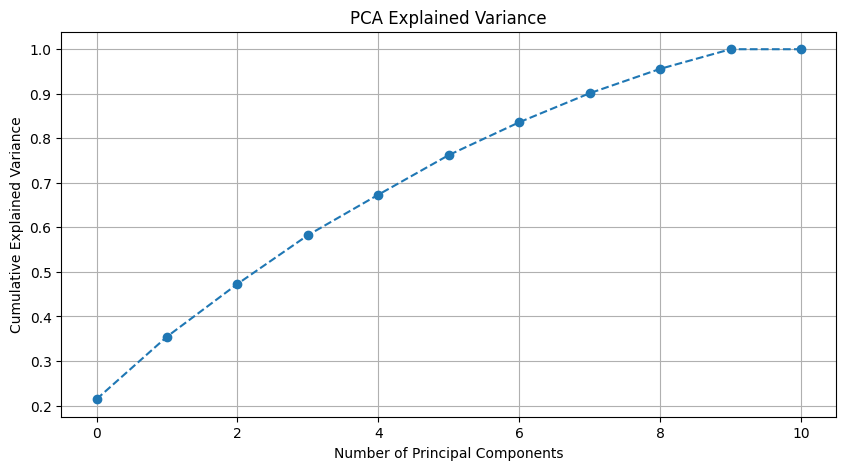

Number of components needed for 95% variance: 9


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# PCA apply
pca = PCA()
pca.fit(df_scaled)

# Cumulative explained variance plot
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.show()

# Find optimal number of components
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components = (cumulative_variance >= 0.95).argmax() + 1

print(f"Number of components needed for 95% variance: {n_components}")

In [8]:
# 4. Apply PCA
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df_scaled)

# 5. Create a DataFrame to store the PCA components
pca_df = pd.DataFrame(data=pca_result, columns=[f'PCA{i+1}' for i in range(n_components)])

# Round the PCA columns to 4 decimal places
pca_df = pca_df.round(4)

# add the explained variance ratio (to see how much variance each component explains)
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance ratio: {explained_variance}')
print(f'Cumulative variance explained: {cumulative_variance[-1]:.4f}')

# Optionally, add the PCA components back to the original dataframe
for i in range(n_components):
    df_delivery[f'PCA{i+1}'] = pca_df[f'PCA{i+1}']

print(f"Number of components needed for 95% variance: {n_components}")

# Convert PCA Output to DataFrame
pca_columns = [f'PCA{i+1}' for i in range(pca_df.shape[1])]
df_pca_final = pd.DataFrame(pca_df.values, columns=pca_columns)

print("Shape of PCA Transformed Data:", df_pca_final.shape)
print(f"PCA Columns:", df_pca_final.columns)

Explained variance ratio: [0.21411258 0.14043622 0.11831707 0.10952292 0.09096113 0.08897392
 0.07368472 0.06517159 0.05472332]
Cumulative variance explained: 1.0000
Number of components needed for 95% variance: 9
Shape of PCA Transformed Data: (530612, 9)
PCA Columns: Index(['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9'], dtype='object')


#### Mutual Information (MI) Score: Rank features based on their correlation with ETA & delays.

In [9]:
# Apply Label Encoding for Full Dataset
encoder = LabelEncoder()
df_encoded = df_sample[categorical_cols].apply(lambda col: encoder.fit_transform(col.astype(str)))

# Target variables
y_eta = df_sample['delivery_eta_minutes']  # Continuous target
y_delayed = df_sample['delivery_time_delay']  # Categorical target (binary: 1 or 0)

# Compute Mutual Information for ETA (continuous target)
mi_eta = mutual_info_regression(df_encoded, y_eta)

# Compute Mutual Information for Delays (categorical target)
mi_delayed = mutual_info_regression(df_encoded, y_delayed)

# Create DataFrames to view the results
mi_eta_df = pd.DataFrame({
    'Feature': df_encoded.columns,
    'MI with ETA': mi_eta
}).sort_values(by='MI with ETA', ascending=False)

mi_delayed_df = pd.DataFrame({
    'Feature': df_encoded.columns,
    'MI with Delayed': mi_delayed
}).sort_values(by='MI with Delayed', ascending=False)

# Print the results
print("Mutual Information with ETA (Continuous Target):")
print(mi_eta_df)

print("\nMutual Information with Delays (Categorical Target):")
print(mi_delayed_df)

Mutual Information with ETA (Continuous Target):
         Feature  MI with ETA
3     is_delayed     0.316158
0  delivery_time     0.214076
2           city     0.107076
1    accept_time     0.093080
4   speed_status     0.011859

Mutual Information with Delays (Categorical Target):
         Feature  MI with Delayed
3     is_delayed         0.315600
0  delivery_time         0.213930
2           city         0.106562
1    accept_time         0.092746
4   speed_status         0.010283


In [12]:
# Select Only Important Features, we'll do it only one time as both eta and delay have same Mi score feature columns
important_categorical_features = mi_eta_df[mi_eta_df['MI with ETA'] > 0.01]['Feature'].tolist()
df_mi_selected_full = df_sample[important_categorical_features]

print("Selected Features (Full Data)", important_categorical_features)

Selected Features (Full Data) ['is_delayed', 'delivery_time', 'city', 'accept_time', 'speed_status']


In [13]:
# Merge PCA-transformed features with MI-selected categorical features for ETA
df_final = pd.concat([
    df_mi_selected_full.reset_index(drop=True), df_pca_final], axis=1)

print("Final Data Shape ETA:", df_final.shape)

Final Data Shape ETA: (530612, 14)


In [14]:
row_count = df_sample.shape[0]
print("Number of rows:", row_count)

Number of rows: 530612


In [15]:
#adding delivery_eta_minutes to the df_final as its needed for model development
df_final = pd.concat([df_final.reset_index(drop=True), df_sample[['delivery_eta_minutes']].reset_index(drop=True)], axis=1)

#### Save data to Postgres

In [326]:
df_final.replace("NaN", pd.NA, inplace=True)  # Convert 'NaN' string to actual NaN
df_final.isna().sum()

is_delayed              0
delivery_time           0
city                    0
accept_time             0
speed_status            0
PCA1                    0
PCA2                    0
PCA3                    0
PCA4                    0
PCA5                    0
PCA6                    0
PCA7                    0
PCA8                    0
PCA9                    0
delivery_eta_minutes    0
dtype: int64

In [327]:
from psycopg2.extras import execute_values

conn = psycopg2.connect(
    host='localhost',
    port=5432,
    user='postgres',
    password='root',
    dbname='postgres'
)

cursor = conn.cursor()

table_name = 'feature_engineering_delivery'

# Step 1: Create a table dynamically based on the DataFrame columns
columns_with_types = []
# Define column types based on the schema
column_types = {
    'delivery_time': 'TIMESTAMP',
    'accept_time': 'TIMESTAMP',
    'city': 'VARCHAR',
    'is_delayed': 'VARCHAR',
    'speed_status': 'VARCHAR', 
    'pca1': 'FLOAT',
    'pca2': 'FLOAT',
    'pca3': 'FLOAT',
    'pca4': 'FLOAT',
    'pca5': 'FLOAT',
    'pca6': 'FLOAT',
    'pca7': 'FLOAT',
    'pca8': 'FLOAT',
    'pca9': 'FLOAT',
    'delivery_eta_minutes': 'FLOAT'
}

# Generate the column definitions with types
for col, dtype in column_types.items():
    columns_with_types.append(f'"{col}" {dtype}')

create_table_query = f"CREATE TABLE IF NOT EXISTS {table_name} ({', '.join(columns_with_types)});"
cursor.execute(create_table_query)

# Step 2: Insert data into the newly created table
insert_query = f"INSERT INTO {table_name} ({', '.join(df_final.columns)}) VALUES %s"
values = df_final.values.tolist()

# Use execute_values to insert multiple rows efficiently
execute_values(cursor, insert_query, values)

# Commit the transaction to make changes persistent
conn.commit()

# Close the cursor and connection
cursor.close()
conn.close()

print(f"Data successfully inserted into the new table '{table_name}'.")

Data successfully inserted into the new table 'feature_engineering_delivery'.


In [328]:
# Save the DataFrame to a CSV file after inserting into the database
output_path = r'C:\Users\Dusty\Downloads\Internship\Last-Mile-Delivery-Delays-and-Route-Optimization\data\feature_pca_mi_delivery.csv'

df_final.to_csv(output_path, index=False)
print("Data saved to csv successfully to csv")

Data saved to csv successfully to csv
